In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Get Data

In [2]:
df1 = pd.read_csv('audio_data.csv')

In [3]:
# Extract MFCC feature columns
X = df1.iloc[:,4:].values

# Convert labels to numeric numbers (0 for cat, 1 for dog)
y = df1["label"].map({"cat": 0, "dog_barking": 1}).values

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
df2 = pd.read_csv('audio_data2.csv')
# Extract MFCC feature columns
X = df2.iloc[:,4:].values

# Convert labels to numeric numbers (0 for cat, 1 for dog)
y = df2["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def reshape_mfcc(mfcc_vector, height=40, width=33):
    padded = np.pad(mfcc_vector, (0, height * width - len(mfcc_vector)), mode='constant')
    return padded.reshape(height, width)

# Reshape all MFCC data
X_train = np.array([reshape_mfcc(x) for x in X_train2])
X_test = np.array([reshape_mfcc(x) for x in X_test2])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train2, dtype=torch.long)
y_test_tensor = torch.tensor(y_test2, dtype=torch.long)


In [6]:
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset
train_dataset = MFCCDataset(X_train_tensor, y_train_tensor)
test_dataset = MFCCDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Create Model

In [7]:
# Model fo audio_data
class CNN_Audio(nn.Module):
    def __init__(self):
        super(CNN_Audio, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 10 * 8, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN_Audio()


In [10]:
# Model fo audio_data2
class CNN_Audio2(nn.Module):
    def __init__(self):
        super(CNN_Audio2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 10 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Train Model

In [13]:
model = CNN_Audio2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # Ensure outputs are of shape [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    test_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {test_losses[-1]}")

print("Training complete!")


Epoch 1/10, Training Loss: 1.4630504479775062, Validation Loss: 1.0685769149235316
Epoch 2/10, Training Loss: 0.9676396617522607, Validation Loss: 0.8507139257022313
Epoch 3/10, Training Loss: 0.7819042366284591, Validation Loss: 0.7425647548266819
Epoch 4/10, Training Loss: 0.654861813554397, Validation Loss: 0.7630724694047656
Epoch 5/10, Training Loss: 0.5596593664242671, Validation Loss: 0.6398275579724994
Epoch 6/10, Training Loss: 0.49787452816963196, Validation Loss: 0.5806407885892051
Epoch 7/10, Training Loss: 0.37734084117871064, Validation Loss: 0.6432470083236694
Epoch 8/10, Training Loss: 0.3188993208683454, Validation Loss: 0.5754217505455017
Epoch 9/10, Training Loss: 0.21439603959711698, Validation Loss: 0.5417180891547885
Epoch 10/10, Training Loss: 0.1761524624262865, Validation Loss: 0.5587654603379113
Training complete!


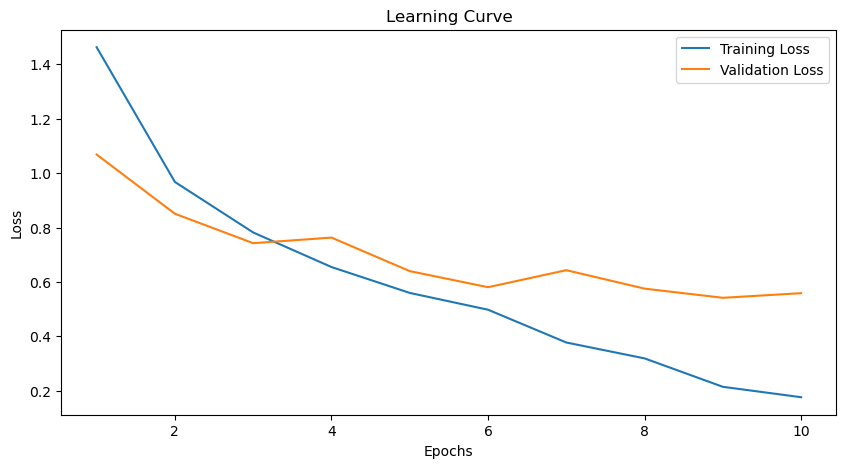

In [15]:
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

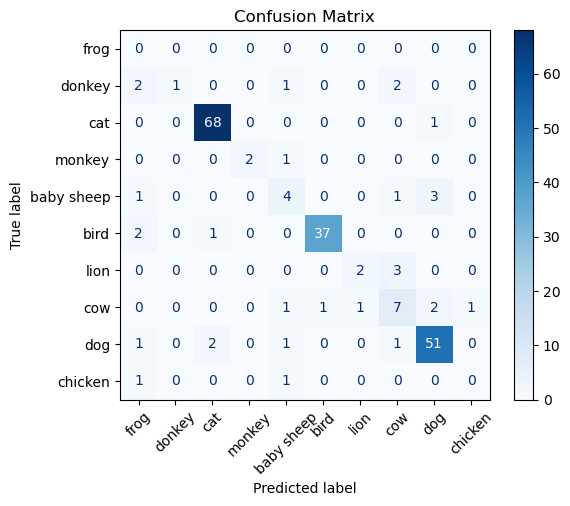

In [33]:
# Evaluate the model on the test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["frog","donkey","cat","monkey","baby sheep","bird","lion","cow","dog","chicken"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))  # Increase the figure size
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.show()

In [19]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.8472906403940886
